<a href="https://colab.research.google.com/github/akshitt/Audio-Processing/blob/main/MFCC_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## What is MFCC
Mel Frequency Cepstral Coefficents ([MFCCs](https://medium.com/prathena/the-dummys-guide-to-mfcc-aceab2450fd)) is a method of extracting features from an audio.   
The MFCC uses the [MEL  scale](https://towardsdatascience.com/getting-to-know-the-mel-spectrogram-31bca3e2d9d0) to divide the frequency band to sub-bands and then extracts the Cepstral Coefficents using [Discrete Cosine Transform](https://www.sciencedirect.com/topics/computer-science/discrete-cosine-transform) (DCT).    
<br>   
## Cepstrum 

- It's the information on rate of change in spectral bands.  
- *Fun Fact* - Cepstrum was first introduced to characterize the seismic echoes resulting due to earthquakes.    
- In the conventional analysis of time signals, any periodic component (for eg, echoes) shows up as sharp peaks in the corresponding frequency spectrum (obtained by Fourier Transform).
- Now,
    - take log of magnitude of frequency spectrum
    - Use DCT to get a spectrum again.
- This is called *quefrency* domain.  And this spectrum was named cepstrum.

<br>    
## MEL Scale
- MEL scale relates the perceived frequency of a tone to the actual measured frequency. This scale has been derived from sets of experiments on human subjects.
-  It scales the frequency in order to match more closely what the human ear can hear (lower frequencies). 
- MEL(f) = 2595 * log(1 + f/700)   
 
<br>   
<img src='https://miro.medium.com/max/700/1*dWnjn5LLS0j8St53ACwqSg.jpeg'>

<br>  
## Human voice Range
- Adult humans fundamental voice frequency range is between 85Hz to 255Hz (85Hz to 180Hz for male and 165Hz to 255Hz for female). Also, there are harmonics of fundamental frequencies.    
- Check out this article [Voice Frequency](https://en.wikipedia.org/wiki/Voice_frequency)   
- Here's the link to [Tone Generator](https://www.szynalski.com/tone-generator/) (generate frequency of any tone)
- The perception of sound is non-linear and you can better distinguish between low frequency sounds than high frequency sounds e.g. humans can clearly hear the difference between 100Hz and 200Hz but not between 15kHz and 15.1kHz.    <br>   




# Implementation



### Loading libraries and audio file

In [2]:
import os
import numpy as np
import scipy
from scipy.io import wavfile
import scipy.fftpack as fft
from scipy.signal import get_window
import IPython.display as ipd
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
%matplotlib inline

audio_link = '/content/drive/My Drive/Summer Projects/Duke/Resources/sample.wav'

Mounted at /content/drive


In [3]:
ipd.Audio(audio_link)

In [4]:
sample_rate, audioo = wavfile.read(audio_link)
print("Sample rate: {0}Hz".format(sample_rate))
print("Audio duration: {0}s".format(len(audioo) / sample_rate))
audio = np.transpose(audioo)
audio = audio[1]
# for i in range(audioo[1])
# print(audio.shape)

Sample rate: 16000Hz
Audio duration: 33.529625s


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  """Entry point for launching an IPython kernel.


In [5]:
def normalize_audio(audio):
    audio = audio / np.max(np.abs(audio))
    return audio

(536474,)


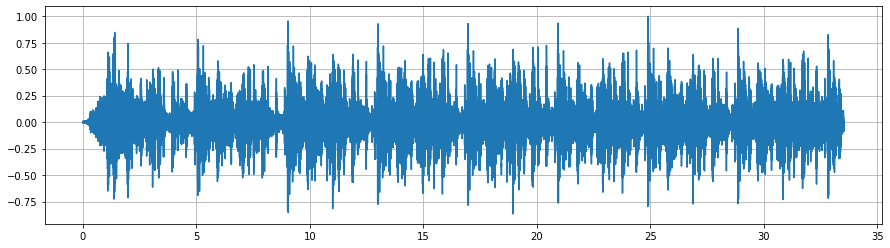

In [7]:
audio = normalize_audio(audio)
print(audio.shape)
plt.figure(figsize=(15,4))
plt.plot(np.linspace(0, len(audio) / sample_rate, num=len(audio)), audio)
plt.grid(True)

### Audio Framing for STFT

We will have a framed audio matrix with the size of (frame number) x (FFT size)

In [10]:
def frame_audio(audio, FFT_size=2048, hop_size=10, sample_rate=16000):

    audio = np.pad(audio, int(FFT_size / 2), mode='reflect')
    frame_len = np.round(sample_rate * hop_size / 1000).astype(int)
    frame_num = int((len(audio) - FFT_size) / frame_len) + 1
    frames = np.zeros((frame_num,FFT_size))
    print(frames.shape)
    for n in range(frame_num):
        frames[n] = audio[n*frame_len:n*frame_len+FFT_size]
    print(audio.shape)
    return frames

In [11]:
hop_size = 15 #ms
FFT_size = 2048

audio_framed = frame_audio(audio, FFT_size, hop_size, sample_rate)
print("Framed audio shape: {0}".format(audio_framed.shape))

(2236, 2048)
(538522,)
Framed audio shape: (2236, 2048)


In [12]:
print("First frame:")
audio_framed[1]
print("Last frame:")
audio_framed[-1]

First frame:
Last frame:


array([ 0.0056548 , -0.00028917,  0.00115666, ...,  0.03180825,
        0.01352654,  0.0003213 ])

### Windowing
Converting from time to frequency domain. 
FFT assumes that audio is periodic.    
To make it continuous, we apply window function, which assures the signal *starts and ends at ZERO*.

Hanning Window is used here.

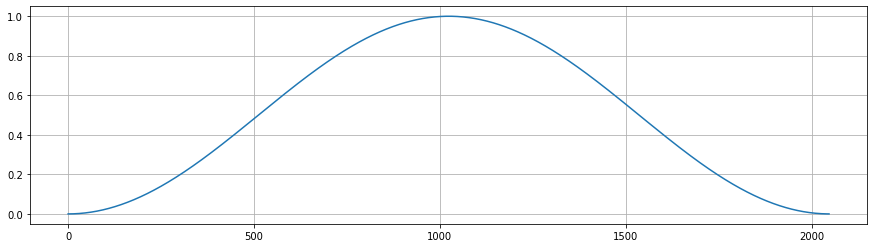

In [13]:
window = get_window("hann", FFT_size, fftbins=True)
plt.figure(figsize=(15,4))
plt.plot(window)
plt.grid(True)

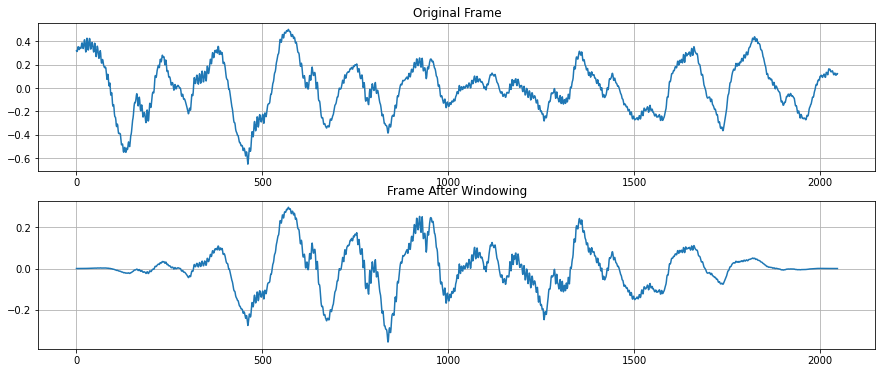

In [16]:
audio_win = audio_framed * window

ind = 345
plt.figure(figsize=(15,6))
plt.subplot(2, 1, 1)
plt.plot(audio_framed[ind])
plt.title('Original Frame')
plt.grid(True)
plt.subplot(2, 1, 2)
plt.plot(audio_win[ind])
plt.title('Frame After Windowing')
plt.grid(True)

### Applying FFT

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


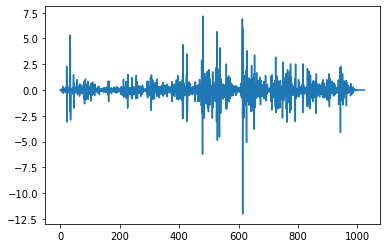

In [17]:
audio_winT = np.transpose(audio_win)

audio_fft = np.empty((int(1 + FFT_size // 2), audio_winT.shape[1]), dtype=np.complex64, order='F')

for n in range(audio_fft.shape[1]):
    audio_fft[:, n] = fft.fft(audio_winT[:, n], axis=0)[:audio_fft.shape[0]]

audio_fft = np.transpose(audio_fft)
plt.plot(audio_fft[45])

In [50]:
audio_power = np.square(np.abs(audio_fft))
print(audio_power.shape)

(2236, 1025)


In [51]:
freq_min = 0
freq_high = sample_rate / 2
mel_filter_num = 10

print("Minimum frequency: {0}".format(freq_min))
print("Maximum frequency: {0}".format(freq_high))

Minimum frequency: 0
Maximum frequency: 8000.0


In [52]:
def freq_to_mel(freq):
    return 2595.0 * np.log10(1.0 + freq / 700.0)

def met_to_freq(mels):
    return 700.0 * (10.0**(mels / 2595.0) - 1.0)

In [59]:
def get_filter_points(fmin, fmax, mel_filter_num, FFT_size, sample_rate=16000):
    fmin_mel = freq_to_mel(fmin)
    fmax_mel = freq_to_mel(fmax)
    
    print("MEL min: {0}".format(fmin_mel))
    print("MEL max: {0}".format(fmax_mel))
    
    mels = np.linspace(fmin_mel, fmax_mel, num=mel_filter_num+2)
    freqs = met_to_freq(mels)
    
    return np.floor((FFT_size + 1) / sample_rate * freqs).astype(int), freqs

In [60]:
filter_points, mel_freqs = get_filter_points(freq_min, freq_high, mel_filter_num, FFT_size, sample_rate=16000)
filter_points

MEL min: 0.0
MEL max: 2840.023046708319


array([   0,   23,   52,   88,  134,  192,  264,  355,  470,  614,  796,
       1024])

In [61]:
def get_filters(filter_points, FFT_size):
    filters = np.zeros((len(filter_points)-2,int(FFT_size/2+1)))
    
    for n in range(len(filter_points)-2):
        filters[n, filter_points[n] : filter_points[n + 1]] = np.linspace(0, 1, filter_points[n + 1] - filter_points[n])
        filters[n, filter_points[n + 1] : filter_points[n + 2]] = np.linspace(1, 0, filter_points[n + 2] - filter_points[n + 1])
    
    return filters

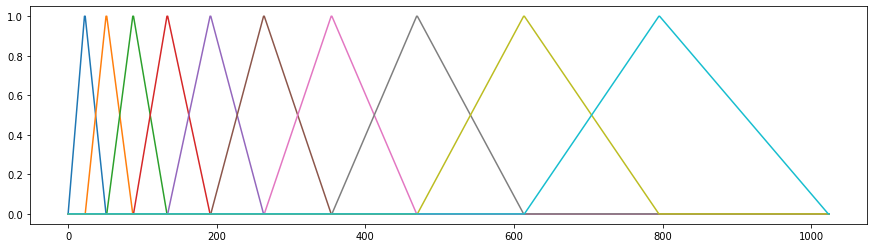

In [63]:
filters = get_filters(filter_points, FFT_size)

plt.figure(figsize=(15,4))
for n in range(filters.shape[0]):
    plt.plot(filters[n])

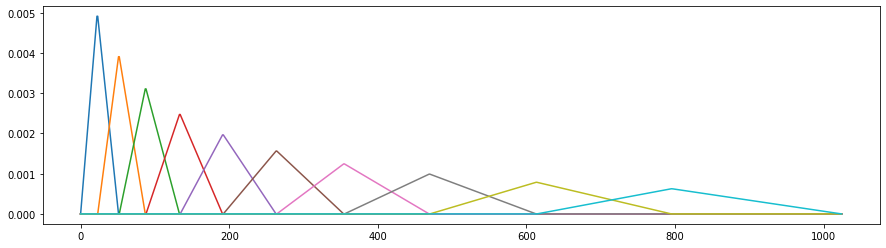

In [64]:
enorm = 2.0 / (mel_freqs[2:mel_filter_num+2] - mel_freqs[:mel_filter_num])
filters *= enorm[:, np.newaxis]

plt.figure(figsize=(15,4))
for n in range(filters.shape[0]):
    plt.plot(filters[n])

In [65]:
audio_filtered = np.dot(filters, np.transpose(audio_power))
audio_log = 10.0 * np.log10(audio_filtered)
audio_log.shape

(10, 2236)

In [66]:
def dct(dct_filter_num, filter_len):
    basis = np.empty((dct_filter_num,filter_len))
    basis[0, :] = 1.0 / np.sqrt(filter_len)
    
    samples = np.arange(1, 2 * filter_len, 2) * np.pi / (2.0 * filter_len)

    for i in range(1, dct_filter_num):
        basis[i, :] = np.cos(i * samples) * np.sqrt(2.0 / filter_len)
        
    return basis

In [67]:
dct_filter_num = 40

dct_filters = dct(dct_filter_num, mel_filter_num)

cepstral_coefficents = np.dot(dct_filters, audio_log)
cepstral_coefficents.shape

(40, 2236)

In [68]:
cepstral_coefficents[:, 0]

array([-1.05092930e+02,  2.31422724e+01, -9.51558309e+00,  3.37563630e+00,
       -1.15907294e+01, -1.55215927e-02, -3.09963241e+00,  2.11623487e+00,
        2.31430165e-01, -6.25426720e-01,  1.72470564e-13,  6.25426720e-01,
       -2.31430165e-01, -2.11623487e+00,  3.09963241e+00,  1.55215927e-02,
        1.15907294e+01, -3.37563630e+00,  9.51558309e+00, -2.31422724e+01,
        1.48623846e+02, -2.31422724e+01,  9.51558309e+00, -3.37563630e+00,
        1.15907294e+01,  1.55215927e-02,  3.09963241e+00, -2.11623487e+00,
       -2.31430165e-01,  6.25426720e-01, -1.02483437e-13, -6.25426720e-01,
        2.31430165e-01,  2.11623487e+00, -3.09963241e+00, -1.55215927e-02,
       -1.15907294e+01,  3.37563630e+00, -9.51558309e+00,  2.31422724e+01])

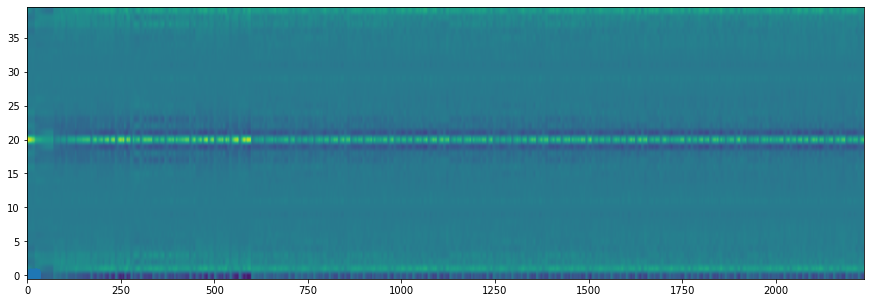

In [69]:
plt.figure(figsize=(15,5))
plt.plot(np.linspace(0, len(audio) / sample_rate, num=len(audio)), audio)
plt.imshow(cepstral_coefficents, aspect='auto', origin='lower');